[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/siowcm/cancer/blob/main/code/02-cancer.ipynb)

Note: Run notebook in colab

# Import libraries

In [ ]:
# import libraries
import glob
import os
import re
import shutil

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from imutils import paths
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    recall_score,
    precision_score
)
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [ ]:
# clone github repo
!git clone https://github.com/siowcm/cancer.git

fatal: destination path 'cancer' already exists and is not an empty directory.


In [ ]:
%cd ./cancer/code

/content/cancer/code


In [ ]:
df = pd.read_csv("../data/cancer.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277524 entries, 0 to 277523
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   patient_id  277524 non-null  int64 
 1   label       277524 non-null  int64 
 2   path        277524 non-null  object
 3   file_name   277524 non-null  object
 4   img_x       277524 non-null  int64 
 5   img_y       277524 non-null  int64 
 6   height      277524 non-null  int64 
 7   width       277524 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 16.9+ MB


# Preprocessing
For preprocessing, the models parameters will be defined and along with some helper functions.

In [ ]:
# parameters
TRAIN_PATH = "../data/train"
VAL_PATH = "../data/val"
TEST_PATH = "../data/test"
IMG_SIZE = (100, 100)
BATCH_SIZE = 64
PATIENCE = 10
NUM_EPOCHS = 100
INIT_LR = 0.01

In [ ]:
# create training, validation and testing data
df_train_and_val, df_test = train_test_split(
    df, train_size=0.8, random_state=42, stratify=df["label"]
)

df_train, df_val = train_test_split(
    df_train_and_val,
    train_size=0.8,
    random_state=42,
    stratify=df_train_and_val["label"],
)

In [ ]:
# check the shape of training and testing data
print(f"Shape of training df: {df_train.shape}")
print(f"Shape of validation df: {df_val.shape}")
print(f"Shape of testing df: {df_test.shape}")

Shape of training df: (177615, 8)
Shape of validation df: (44404, 8)
Shape of testing df: (55505, 8)


In [ ]:
# create folder/ subfolders if it does not exist
for folder in [TRAIN_PATH, VAL_PATH, TEST_PATH]:
    if not os.path.exists(folder):
        os.makedirs(folder)
    if not os.path.exists(os.path.join(folder, "0")):
        os.makedirs(os.path.join(folder, "0"))
    if not os.path.exists(os.path.join(folder, "1")):
        os.makedirs(os.path.join(folder, "1"))

In [ ]:
# copy to newly created folders
for index, data in df_train.iterrows():
    shutil.copy2(data["path"], os.path.join(TRAIN_PATH, str(data["label"])))

for index, data in df_val.iterrows():
    shutil.copy2(data["path"], os.path.join(VAL_PATH, str(data["label"])))

for index, data in df_test.iterrows():
    shutil.copy2(data["path"], os.path.join(TEST_PATH, str(data["label"])))

In [ ]:
# check folder structure
!apt-get install tree
!cd ../data ; tree --dirsfirst --filelimit 5

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
.
├── archive [280 entries exceeds filelimit, not opening dir]
├── test
│   ├── 0 [39748 entries exceeds filelimit, not opening dir]
│   └── 1 [15757 entries exceeds filelimit, not opening dir]
├── train
│   ├── 0 [127192 entries exceeds filelimit, not opening dir]
│   └── 1 [50423 entries exceeds filelimit, not opening dir]
├── val
│   ├── 0 [31798 entries exceeds filelimit, not opening dir]
│   └── 1 [12606 entries exceeds filelimit, not opening dir]
└── cancer.csv

10 directories, 1 file


In [ ]:
# create list pf images paths
train_paths = list(paths.list_images(TRAIN_PATH))
val_paths = list(paths.list_images(VAL_PATH))
test_paths = list(paths.list_images(TEST_PATH))

# print output for clarity
print(train_paths[:2])
print(val_paths[:2])
print(test_paths[:2])

['../data/train/0/13916_idx5_x401_y1751_class0.png', '../data/train/0/13400_idx5_x1851_y1551_class0.png']
['../data/val/0/9382_idx5_x3151_y2401_class0.png', '../data/val/0/15472_idx5_x801_y601_class0.png']
['../data/test/0/10302_idx5_x551_y2151_class0.png', '../data/test/0/10269_idx5_x851_y1551_class0.png']


In [ ]:
# create class weights
train_labels = [int(p.split(os.path.sep)[-2]) for p in train_paths]
train_labels = keras.utils.to_categorical(
    train_labels
)  # one-hot encode list into arrary
class_totals = train_labels.sum(axis=0)
class_weight = {}
for i in range(0, len(class_totals)):
    class_weight[i] = class_totals.max() / class_totals[i]
print(f"class weights: {class_weight}")

class weights: {0: 1.0, 1: 2.5224996}


In [ ]:
# function to augment images
@tf.function                                        # decarator code to create Python-independent dataflow graphs out of your Python code.
def augmentation(image, label):                     # This will help you create performant and portable model.
    '''
    Takes in image tensor and label and
    return respective inputs after transformation
    '''
    image = tf.image.random_flip_left_right(image)  # random horizontal flips
    image = tf.image.random_flip_up_down(image)     # random horizontal flips
    return image, label                             # more augmenetation from tensorflow API https://www.tensorflow.org/api_docs/python/tf/image

In [ ]:
def compile_fit_model(model, save_path, train_data, val_data):
    '''
    Takes in model object and string for saved path for training.
    Return model after training.
    '''
    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=INIT_LR),
        metrics=[
            keras.metrics.BinaryAccuracy(),
            keras.metrics.AUC(),
            keras.metrics.Precision(),
            keras.metrics.Recall(),
        ],
    )

    callbacks_list = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=PATIENCE, restore_best_weights=True
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=save_path, verbose=1, save_best_only=True
        ),
        keras.callbacks.ReduceLROnPlateau(verbose=1),
    ]

    history = model.fit(
        x=train_data,
        epochs=NUM_EPOCHS,
        callbacks=callbacks_list,
        validation_data=val_data,
        class_weight=class_weight,
        steps_per_epoch=len(train_data) // BATCH_SIZE,
        # validation_steps=len(val_data) // BATCH_SIZE,
    )

    return history, model

# Transfer Learning

In this section, the models will be built by using the convolution network of the pre-trained model (e.g. VGG16) as a backbone to extract features and add a fully-connected layer. 

## VGG16

In [ ]:
# function to load image
def image_loader_vgg16(path):
    image = tf.io.read_file(path)                                   # read image file as binary
    image = tf.image.decode_png(image, channels=3)                  # decode into image tensor
    # image = tf.image.convert_image_dtype(image, dtype=tf.float32) # converts to float32 data type and scaling the values appropriately before casting.
    image = tf.cast(image, dtype=tf.float32)
    image = tf.image.resize(image, IMG_SIZE)                        # resize the image
    image = keras.applications.vgg16.preprocess_input(image)        # custom preprocessing for VGG16
    label = tf.strings.split(path, os.path.sep)[-2]                 # parse the class label from the file path
    label = tf.strings.to_number(label, tf.int32)
    return (image, label)

In [ ]:
train_data_vgg = tf.data.Dataset.from_tensor_slices(train_paths)
train_data_vgg = (
    train_data_vgg.shuffle(len(train_paths))                            # shuffle data, optional as already did train_test_split in scikit-learn
    .map(image_loader_vgg16, num_parallel_calls=tf.data.AUTOTUNE)   # load the image
    .map(augmentation, num_parallel_calls=tf.data.AUTOTUNE)         # apply augmentation
    .cache()                                                        # caching for fast read
    .batch(batch_size=BATCH_SIZE)                                   # batching the data
    .prefetch(tf.data.AUTOTUNE)                                     # allows later elements to be prepared while the current element is being processed
)


val_data_vgg = tf.data.Dataset.from_tensor_slices(val_paths)                   # no augmentation & shuffle required for test data as it is ground truth
val_data_vgg = (
    val_data_vgg.map(image_loader_vgg16, num_parallel_calls=tf.data.AUTOTUNE)  # load the image
    .batch(batch_size=BATCH_SIZE)                                          # batching the data
    .prefetch(tf.data.AUTOTUNE)                                            # allows later elements to be prepared while the current element is being processed
)


test_data_vgg = tf.data.Dataset.from_tensor_slices(test_paths)                  # no augmentation & shuffle required for test data as it is ground truth
test_data_vgg = (
    test_data_vgg.map(image_loader_vgg16, num_parallel_calls=tf.data.AUTOTUNE)  # load the image
    .batch(batch_size=BATCH_SIZE)                                           # batching the data
    .prefetch(tf.data.AUTOTUNE)                                             # allows later elements to be prepared while the current element is being processed
)

In [ ]:
#import pretrained and freeze the layers
VGG16 = keras.applications.VGG16(include_top=False, weights="imagenet")
VGG16.trainable = False

In [ ]:
#add custom binary prediction layer
model_vgg16 = keras.models.Sequential(
    [
        VGG16,
        # keras.layers.BatchNormalization(),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)

In [ ]:
model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

In [ ]:
#train model
history_vgg16, model_vgg16 = compile_fit_model(
    model=model_vgg16,
    save_path="vgg16.h5",
    train_data=train_data_vgg,
    val_data=val_data_vgg
)

Epoch 1/100
43/43 [==============================] - ETA: 0s - loss: 2.1800 - binary_accuracy: 0.7035 - auc: 0.7227 - precision: 0.4899 - recall: 0.6725
Epoch 1: val_loss improved from inf to 0.44296, saving model to vgg16.h5
43/43 [==============================] - 39s 665ms/step - loss: 2.1800 - binary_accuracy: 0.7035 - auc: 0.7227 - precision: 0.4899 - recall: 0.6725 - val_loss: 0.4430 - val_binary_accuracy: 0.8175 - val_auc: 0.8644 - val_precision: 0.6552 - val_recall: 0.7538 - lr: 0.0100
Epoch 2/100
43/43 [==============================] - ETA: 0s - loss: 0.6654 - binary_accuracy: 0.7936 - auc: 0.8683 - precision: 0.6112 - recall: 0.7849
Epoch 2: val_loss improved from 0.44296 to 0.41745, saving model to vgg16.h5
43/43 [==============================] - 26s 618ms/step - loss: 0.6654 - binary_accuracy: 0.7936 - auc: 0.8683 - precision: 0.6112 - recall: 0.7849 - val_loss: 0.4174 - val_binary_accuracy: 0.8269 - val_auc: 0.8813 - val_precision: 0.6712 - val_recall: 0.7653 - lr: 0.010

In [ ]:
#evaluate with test data
vgg16_eval = model_vgg16.evaluate(test_data_vgg)
vgg16_eval

868/868 [==============================] - 31s 35ms/step - loss: 0.3602 - binary_accuracy: 0.8454 - auc: 0.8979 - precision: 0.7327 - recall: 0.7168


[0.36021125316619873,
 0.8453652858734131,
 0.8978773355484009,
 0.7327105402946472,
 0.7167608141899109]

In [ ]:
result_vgg16 = pd.DataFrame(history_vgg16.history)

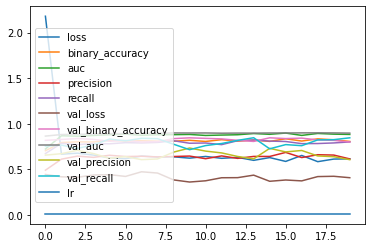

In [ ]:
result_vgg16.plot()

## EfficientNetB0

In [ ]:
# function to load image
def image_loader_effnetb0(path):
    image = tf.io.read_file(path)                                    # read image file as binary
    image = tf.image.decode_png(image, channels=3)                   # decode into image tensor
    # image = tf.image.convert_image_dtype(image, dtype=tf.float32)  # converts to float32 data type and scaling the values appropriately before casting.
    image = tf.image.resize(image, IMG_SIZE)                         # resize the image
    image = keras.applications.efficientnet.preprocess_input(image)  # custom preprocessing for efficientnet
    label = tf.strings.split(path, os.path.sep)[-2]                  # parse the class label from the file path
    label = tf.strings.to_number(label, tf.int32)
    return (image, label)

In [ ]:
train_data_eff = tf.data.Dataset.from_tensor_slices(train_paths)
train_data_eff = (
    train_data_eff.shuffle(len(train_paths))                              # shuffle data, optional as already did train_test_split in scikit-learn
    .map(image_loader_effnetb0, num_parallel_calls=tf.data.AUTOTUNE)  # load the image
    .map(augmentation, num_parallel_calls=tf.data.AUTOTUNE)           # apply augmentation
    .cache()                                                          # caching for fast read
    .batch(batch_size=BATCH_SIZE)                                     # batching the data
    .prefetch(tf.data.AUTOTUNE)                                       # allows later elements to be prepared while the current element is being processed
)


val_data_eff = tf.data.Dataset.from_tensor_slices(val_paths)                      # no augmentation & shuffle required for test data as it is ground truth
val_data_eff = (
    val_data_eff.map(image_loader_effnetb0, num_parallel_calls=tf.data.AUTOTUNE)  # load the image
    .batch(batch_size=BATCH_SIZE)                                             # batching the data
    .prefetch(tf.data.AUTOTUNE)                                               # allows later elements to be prepared while the current element is being processed
)


test_data_eff = tf.data.Dataset.from_tensor_slices(test_paths)                     # no augmentation & shuffle required for test data as it is ground truth
test_data_eff = (
    test_data_eff.map(image_loader_effnetb0, num_parallel_calls=tf.data.AUTOTUNE)  # load the image
    .batch(batch_size=BATCH_SIZE)                                              # batching the data
    .prefetch(tf.data.AUTOTUNE)                                                # allows later elements to be prepared while the current element is being processed  
)

In [ ]:
#import pretrained and freeze the layers
effnetb0 = keras.applications.EfficientNetB0(include_top=False, weights="imagenet")
effnetb0.trainable = False

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model_effnetb0 = keras.models.Sequential(
    [
        effnetb0,
        # keras.layers.BatchNormalization(),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)

In [ ]:
model_effnetb0.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                      

In [ ]:
history_effnetb0, model_effnetb0 = compile_fit_model(
    model=model_effnetb0,
    save_path="effnetb0.h5", 
    train_data=train_data_eff, 
    val_data=val_data_eff
)

Epoch 1/100
43/43 [==============================] - ETA: 0s - loss: 0.8077 - binary_accuracy: 0.7449 - auc_1: 0.8024 - precision_1: 0.5398 - recall_1: 0.7172
Epoch 1: val_loss improved from inf to 0.44209, saving model to effnetb0.h5
43/43 [==============================] - 25s 438ms/step - loss: 0.8077 - binary_accuracy: 0.7449 - auc_1: 0.8024 - precision_1: 0.5398 - recall_1: 0.7172 - val_loss: 0.4421 - val_binary_accuracy: 0.8147 - val_auc_1: 0.8730 - val_precision_1: 0.6482 - val_recall_1: 0.7592 - lr: 0.0100
Epoch 2/100
43/43 [==============================] - ETA: 0s - loss: 0.6338 - binary_accuracy: 0.8016 - auc_1: 0.8754 - precision_1: 0.6068 - recall_1: 0.7971
Epoch 2: val_loss improved from 0.44209 to 0.41375, saving model to effnetb0.h5
43/43 [==============================] - 17s 397ms/step - loss: 0.6338 - binary_accuracy: 0.8016 - auc_1: 0.8754 - precision_1: 0.6068 - recall_1: 0.7971 - val_loss: 0.4138 - val_binary_accuracy: 0.8120 - val_auc_1: 0.8775 - val_precision_1:

In [ ]:
effnet_eval = model_effnetb0.evaluate(test_data_eff)
effnet_eval

868/868 [==============================] - 22s 25ms/step - loss: 0.3742 - binary_accuracy: 0.8408 - auc_1: 0.8934 - precision_1: 0.7166 - recall_1: 0.7264


[0.37415462732315063,
 0.8407710790634155,
 0.8934152126312256,
 0.7165842652320862,
 0.7264072895050049]

In [ ]:
result_effnetb0 = pd.DataFrame(history_effnetb0.history)

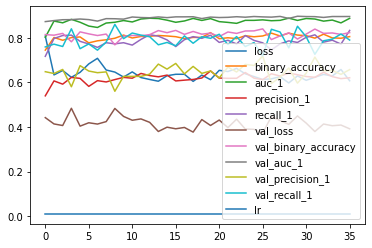

In [ ]:
result_effnetb0.plot()

## Xception

In [ ]:
# function to load image
def image_loader_xception(path):
    image = tf.io.read_file(path)                                   # read image file as binary
    image = tf.image.decode_png(image, channels=3)                  # decode into image tensor
    # image = tf.image.convert_image_dtype(image, dtype=tf.float32) # converts to float32 data type and scaling the values appropriately before casting.
    image = tf.cast(image, dtype=tf.float32)
    image = tf.image.resize(image, IMG_SIZE)                        # resize the image
    image = keras.applications.xception.preprocess_input(image)     # custom preprocessing for VGG16
    label = tf.strings.split(path, os.path.sep)[-2]                 # parse the class label from the file path
    label = tf.strings.to_number(label, tf.int32)
    return (image, label)


In [ ]:
train_data_xcep = tf.data.Dataset.from_tensor_slices(train_paths)
train_data_xcep = (
    train_data_xcep.shuffle(len(train_paths))                            # shuffle data, optional as already did train_test_split in scikit-learn
    .map(image_loader_xception, num_parallel_calls=tf.data.AUTOTUNE)   # load the image
    .map(augmentation, num_parallel_calls=tf.data.AUTOTUNE)         # apply augmentation
    .cache()                                                        # caching for fast read
    .batch(batch_size=BATCH_SIZE)                                   # batching the data
    .prefetch(tf.data.AUTOTUNE)                                     # allows later elements to be prepared while the current element is being processed
)


val_data_xcep = tf.data.Dataset.from_tensor_slices(val_paths)                   # no augmentation & shuffle required for test data as it is ground truth
val_data_xcep = (
    val_data_xcep.map(image_loader_xception, num_parallel_calls=tf.data.AUTOTUNE)  # load the image
    .batch(batch_size=BATCH_SIZE)                                          # batching the data
    .prefetch(tf.data.AUTOTUNE)                                            # allows later elements to be prepared while the current element is being processed
)


test_data_xcep = tf.data.Dataset.from_tensor_slices(test_paths)                  # no augmentation & shuffle required for test data as it is ground truth
test_data_xcep = (
    test_data_xcep.map(image_loader_xception, num_parallel_calls=tf.data.AUTOTUNE)  # load the image
    .batch(batch_size=BATCH_SIZE)                                           # batching the data
    .prefetch(tf.data.AUTOTUNE)                                             # allows later elements to be prepared while the current element is being processed
)

In [ ]:
xception = keras.applications.Xception(include_top=False, weights="imagenet")
xception.trainable = False

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
model_xception = keras.models.Sequential(
    [
        xception,
        # keras.layers.BatchNormalization(),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)

In [ ]:
model_xception.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                      

In [ ]:
history_xception, model_xception = compile_fit_model(
    model=model_xception, 
    save_path="xception.h5", 
    train_data=train_data_xcep, 
    val_data=val_data_xcep
)

Epoch 1/100
43/43 [==============================] - ETA: 0s - loss: 1.1819 - binary_accuracy: 0.7148 - auc_2: 0.7364 - precision_2: 0.4962 - recall_2: 0.6718
Epoch 1: val_loss improved from inf to 0.50681, saving model to xception.h5
43/43 [==============================] - 27s 562ms/step - loss: 1.1819 - binary_accuracy: 0.7148 - auc_2: 0.7364 - precision_2: 0.4962 - recall_2: 0.6718 - val_loss: 0.5068 - val_binary_accuracy: 0.7694 - val_auc_2: 0.8556 - val_precision_2: 0.5652 - val_recall_2: 0.8133 - lr: 0.0100
Epoch 2/100
43/43 [==============================] - ETA: 0s - loss: 0.7002 - binary_accuracy: 0.7889 - auc_2: 0.8523 - precision_2: 0.6053 - recall_2: 0.7918
Epoch 2: val_loss improved from 0.50681 to 0.43830, saving model to xception.h5
43/43 [==============================] - 23s 535ms/step - loss: 0.7002 - binary_accuracy: 0.7889 - auc_2: 0.8523 - precision_2: 0.6053 - recall_2: 0.7918 - val_loss: 0.4383 - val_binary_accuracy: 0.8125 - val_auc_2: 0.8667 - val_precision_2:

In [ ]:
xception_eval = model_xception.evaluate(test_data_xcep)
xception_eval

868/868 [==============================] - 28s 32ms/step - loss: 0.3652 - binary_accuracy: 0.8387 - auc_2: 0.8965 - precision_2: 0.7054 - recall_2: 0.7413


[0.36518535017967224,
 0.8386812210083008,
 0.8965451717376709,
 0.7054169774055481,
 0.741321325302124]

In [ ]:
result_xception = pd.DataFrame(history_xception.history)

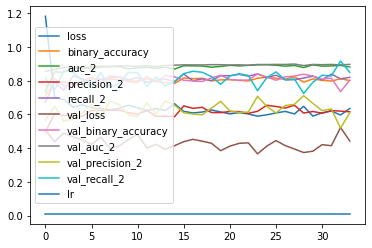

In [ ]:
result_xception.plot()

## DenseNet121

In [ ]:
# function to load image
def image_loader_densenet121(path):
    image = tf.io.read_file(path)                                   # read image file as binary
    image = tf.image.decode_png(image, channels=3)                  # decode into image tensor
    # image = tf.image.convert_image_dtype(image, dtype=tf.float32) # converts to float32 data type and scaling the values appropriately before casting.
    image = tf.cast(image, dtype=tf.float32)
    image = tf.image.resize(image, IMG_SIZE)                        # resize the image
    image = keras.applications.densenet.preprocess_input(image)        # custom preprocessing for VGG16
    label = tf.strings.split(path, os.path.sep)[-2]                 # parse the class label from the file path
    label = tf.strings.to_number(label, tf.int32)
    return (image, label)


In [ ]:
train_data_dense = tf.data.Dataset.from_tensor_slices(train_paths)
train_data_dense = (
    train_data_dense.shuffle(len(train_paths))                            # shuffle data, optional as already did train_test_split in scikit-learn
    .map(image_loader_densenet121, num_parallel_calls=tf.data.AUTOTUNE)   # load the image
    .map(augmentation, num_parallel_calls=tf.data.AUTOTUNE)         # apply augmentation
    .cache()                                                        # caching for fast read
    .batch(batch_size=BATCH_SIZE)                                   # batching the data
    .prefetch(tf.data.AUTOTUNE)                                     # allows later elements to be prepared while the current element is being processed
)


val_data_dense = tf.data.Dataset.from_tensor_slices(val_paths)                   # no augmentation & shuffle required for test data as it is ground truth
val_data_dense = (
    val_data_dense.map(image_loader_densenet121, num_parallel_calls=tf.data.AUTOTUNE)  # load the image
    .batch(batch_size=BATCH_SIZE)                                          # batching the data
    .prefetch(tf.data.AUTOTUNE)                                            # allows later elements to be prepared while the current element is being processed
)


test_data_dense = tf.data.Dataset.from_tensor_slices(test_paths)                  # no augmentation & shuffle required for test data as it is ground truth
test_data_dense = (
    test_data_dense.map(image_loader_densenet121, num_parallel_calls=tf.data.AUTOTUNE)  # load the image
    .batch(batch_size=BATCH_SIZE)                                           # batching the data
    .prefetch(tf.data.AUTOTUNE)                                             # allows later elements to be prepared while the current element is being processed
)

In [ ]:
densenet121 = keras.applications.DenseNet121(include_top=False, weights="imagenet")
densenet121.trainable = False

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
model_densenet121 = keras.models.Sequential(
    [
        densenet121,
        # keras.layers.BatchNormalization(),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)

In [ ]:
model_densenet121.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_3 (Flatten)         (None, 1024)              0         
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               131200    
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                      

In [ ]:
history_densenet121, model_densenet121 = compile_fit_model(
    model=model_densenet121, 
    save_path="densenet152.h5", 
    train_data=train_data_dense, 
    val_data=val_data_dense
)

Epoch 1/100
43/43 [==============================] - ETA: 0s - loss: 1.4160 - binary_accuracy: 0.5872 - auc_3: 0.7465 - precision_3: 0.3853 - recall_3: 0.7891
Epoch 1: val_loss improved from inf to 0.62614, saving model to densenet152.h5
43/43 [==============================] - 31s 585ms/step - loss: 1.4160 - binary_accuracy: 0.5872 - auc_3: 0.7465 - precision_3: 0.3853 - recall_3: 0.7891 - val_loss: 0.6261 - val_binary_accuracy: 0.8216 - val_auc_3: 0.8125 - val_precision_3: 0.6826 - val_recall_3: 0.6947 - lr: 0.0100
Epoch 2/100
43/43 [==============================] - ETA: 0s - loss: 0.7659 - binary_accuracy: 0.8165 - auc_3: 0.8168 - precision_3: 0.6535 - recall_3: 0.7012
Epoch 2: val_loss improved from 0.62614 to 0.55254, saving model to densenet152.h5
43/43 [==============================] - 23s 536ms/step - loss: 0.7659 - binary_accuracy: 0.8165 - auc_3: 0.8168 - precision_3: 0.6535 - recall_3: 0.7012 - val_loss: 0.5525 - val_binary_accuracy: 0.8393 - val_auc_3: 0.8450 - val_precis

In [ ]:
densenet_eval = model_densenet121.evaluate(test_data_dense)
densenet_eval

868/868 [==============================] - 28s 32ms/step - loss: 0.3646 - binary_accuracy: 0.8532 - auc_3: 0.9081 - precision_3: 0.7309 - recall_3: 0.7643


[0.3646146357059479,
 0.8532024025917053,
 0.9081313610076904,
 0.7308976054191589,
 0.764295220375061]

In [ ]:
result_densenet121 = pd.DataFrame(history_densenet121.history)

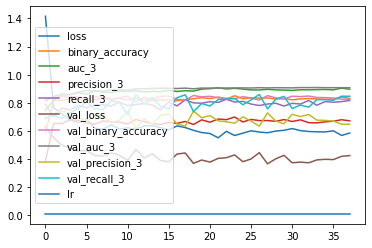

In [ ]:
result_densenet121.plot()

### Hyperparameters Tuning 

Using keras tuner API, hyperparameters for densnet will be further fine-tuned.

The evaluation with test showes that hyperparameter tuning produce a slightly better reuslt.

In [169]:
# function to load image
def image_loader_densenet121(path):
    image = tf.io.read_file(path)                                   # read image file as binary
    image = tf.image.decode_png(image, channels=3)                  # decode into image tensor
    # image = tf.image.convert_image_dtype(image, dtype=tf.float32) # converts to float32 data type and scaling the values appropriately before casting.
    image = tf.cast(image, dtype=tf.float32)
    image = tf.image.resize(image, IMG_SIZE)                        # resize the image
    image = keras.applications.densenet.preprocess_input(image)        # custom preprocessing for VGG16
    label = tf.strings.split(path, os.path.sep)[-2]                 # parse the class label from the file path
    label = tf.strings.to_number(label, tf.int32)
    return (image, label)

In [170]:
train_data_dense = tf.data.Dataset.from_tensor_slices(train_paths)
train_data_dense = (
    train_data_dense.shuffle(len(train_paths))                            # shuffle data, optional as already did train_test_split in scikit-learn
    .map(image_loader_densenet121, num_parallel_calls=tf.data.AUTOTUNE)   # load the image
    .map(augmentation, num_parallel_calls=tf.data.AUTOTUNE)         # apply augmentation
    .cache()                                                        # caching for fast read
    .batch(batch_size=BATCH_SIZE)                                   # batching the data
    .prefetch(tf.data.AUTOTUNE)                                     # allows later elements to be prepared while the current element is being processed
)


val_data_dense = tf.data.Dataset.from_tensor_slices(val_paths)                   # no augmentation & shuffle required for test data as it is ground truth
val_data_dense = (
    val_data_dense.map(image_loader_densenet121, num_parallel_calls=tf.data.AUTOTUNE)  # load the image
    .batch(batch_size=BATCH_SIZE)                                          # batching the data
    .prefetch(tf.data.AUTOTUNE)                                            # allows later elements to be prepared while the current element is being processed
)


test_data_dense = tf.data.Dataset.from_tensor_slices(test_paths)                  # no augmentation & shuffle required for test data as it is ground truth
test_data_dense = (
    test_data_dense.map(image_loader_densenet121, num_parallel_calls=tf.data.AUTOTUNE)  # load the image
    .batch(batch_size=BATCH_SIZE)                                           # batching the data
    .prefetch(tf.data.AUTOTUNE)                                             # allows later elements to be prepared while the current element is being processed
)

In [171]:
densenet121 = keras.applications.DenseNet121(include_top=False, weights="imagenet")
densenet121.trainable = False

In [172]:
!pip install keras-tuner -q

     |████████████████████████████████| 133 kB 7.3 MB/s 


In [173]:
import keras_tuner as kt


def tune_model(hp):
    model_densenet121 = keras.models.Sequential(
        [
            densenet121,
            keras.layers.BatchNormalization(),
            keras.layers.GlobalAveragePooling2D(),
            keras.layers.Dropout(hp.Choice("dropout", [0.2, 0.3, 0.4, 0.5])),
            keras.layers.Flatten(),
            keras.layers.Dense(
                hp.Int("units", min_value=16, max_value=512, step=32),
                activation="relu",
            ),
            keras.layers.Dense(units=1, activation="sigmoid"),
        ]
    )

    model_densenet121.compile(
        loss="binary_crossentropy",
        optimizer=hp.Choice("optimizer", ["adam", "sgd", "nadam"]),
        metrics=[
            keras.metrics.BinaryAccuracy(),
            keras.metrics.AUC(),
            keras.metrics.Precision(),
            keras.metrics.Recall(),
        ],
    )
    return model_densenet121

In [174]:
tuner = kt.Hyperband(tune_model, objective="val_loss", max_epochs=5)

In [175]:
tuner.search(
    train_data_dense,
    steps_per_epoch=len(train_data_dense) // BATCH_SIZE,
    epochs=5,
    validation_data=val_data_dense,
    validation_steps=len(val_data_dense) // BATCH_SIZE,
)

Trial 10 Complete [00h 00m 21s]
val_loss: 0.0806564912199974

Best val_loss So Far: 0.06673961877822876
Total elapsed time: 00h 03m 13s
INFO:tensorflow:Oracle triggered exit


In [176]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
dropout: 0.3
units: 400
optimizer: adam
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.06673961877822876
Trial summary
Hyperparameters:
dropout: 0.2
units: 176
optimizer: nadam
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.07138364017009735
Trial summary
Hyperparameters:
dropout: 0.4
units: 496
optimizer: nadam
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0001
Score: 0.0766867846250534
Trial summary
Hyperparameters:
dropout: 0.5
units: 112
optimizer: nadam
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.0806564912199974
Trial summary
Hyperparameters:
dropout: 0.4
units: 496
optimizer: nadam
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.08473367989063263
Trial summary
Hyperparameters:
dropout: 0.3
units: 400
optimize

In [177]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model_tuned = tuner.hypermodel.build(best_hps)

In [178]:
history_densenet121_tuned, model_densenet121_tuned = compile_fit_model(
    model=model_tuned,
    save_path="densenet152_tuned.h5",
    train_data = train_data_dense,
    val_data=val_data_dense
)

Epoch 1/100
43/43 [==============================] - ETA: 0s - loss: 1.0121 - binary_accuracy: 0.7547 - auc_2: 0.8218 - precision_2: 0.5534 - recall_2: 0.7824
Epoch 1: val_loss improved from inf to 0.51077, saving model to densenet152_tuned.h5
43/43 [==============================] - 31s 592ms/step - loss: 1.0121 - binary_accuracy: 0.7547 - auc_2: 0.8218 - precision_2: 0.5534 - recall_2: 0.7824 - val_loss: 0.5108 - val_binary_accuracy: 0.7683 - val_auc_2: 0.8447 - val_precision_2: 0.5617 - val_recall_2: 0.8372 - lr: 0.0100
Epoch 2/100
43/43 [==============================] - ETA: 0s - loss: 0.5937 - binary_accuracy: 0.8081 - auc_2: 0.8964 - precision_2: 0.6276 - recall_2: 0.8321
Epoch 2: val_loss improved from 0.51077 to 0.43120, saving model to densenet152_tuned.h5
43/43 [==============================] - 23s 541ms/step - loss: 0.5937 - binary_accuracy: 0.8081 - auc_2: 0.8964 - precision_2: 0.6276 - recall_2: 0.8321 - val_loss: 0.4312 - val_binary_accuracy: 0.8392 - val_auc_2: 0.8899 

In [179]:
tuned_densenet = model_densenet121_tuned.evaluate(test_data_dense)
tuned_densenet

868/868 [==============================] - 28s 32ms/step - loss: 0.3263 - binary_accuracy: 0.8587 - auc_2: 0.9228 - precision_2: 0.7262 - recall_2: 0.8065


[0.3262534439563751,
 0.8587334752082825,
 0.922759473323822,
 0.7261714339256287,
 0.8064987063407898]

## ResNet152V2 

In [ ]:
# function to load image
def image_loader_resnet152(path):
    image = tf.io.read_file(path)                                   # read image file as binary
    image = tf.image.decode_png(image, channels=3)                  # decode into image tensor
    # image = tf.image.convert_image_dtype(image, dtype=tf.float32) # converts to float32 data type and scaling the values appropriately before casting.
    image = tf.cast(image, dtype=tf.float32)
    image = tf.image.resize(image, IMG_SIZE)                        # resize the image
    image = keras.applications.resnet_v2.preprocess_input(image)        # custom preprocessing for VGG16
    label = tf.strings.split(path, os.path.sep)[-2]                 # parse the class label from the file path
    label = tf.strings.to_number(label, tf.int32)
    return (image, label)


In [ ]:
train_data_res = tf.data.Dataset.from_tensor_slices(train_paths)
train_data_res = (
    train_data_res.shuffle(len(train_paths))                            # shuffle data, optional as already did train_test_split in scikit-learn
    .map(image_loader_resnet152, num_parallel_calls=tf.data.AUTOTUNE)   # load the image
    .map(augmentation, num_parallel_calls=tf.data.AUTOTUNE)         # apply augmentation
    .cache()                                                        # caching for fast read
    .batch(batch_size=BATCH_SIZE)                                   # batching the data
    .prefetch(tf.data.AUTOTUNE)                                     # allows later elements to be prepared while the current element is being processed
)


val_data_res = tf.data.Dataset.from_tensor_slices(val_paths)                   # no augmentation & shuffle required for test data as it is ground truth
val_data_res = (
    val_data_res.map(image_loader_resnet152, num_parallel_calls=tf.data.AUTOTUNE)  # load the image
    .batch(batch_size=BATCH_SIZE)                                          # batching the data
    .prefetch(tf.data.AUTOTUNE)                                            # allows later elements to be prepared while the current element is being processed
)


test_data_res = tf.data.Dataset.from_tensor_slices(test_paths)                  # no augmentation & shuffle required for test data as it is ground truth
test_data_res = (
    test_data_res.map(image_loader_resnet152, num_parallel_calls=tf.data.AUTOTUNE)  # load the image
    .batch(batch_size=BATCH_SIZE)                                           # batching the data
    .prefetch(tf.data.AUTOTUNE)                                             # allows later elements to be prepared while the current element is being processed
)

In [ ]:
resnet152 = keras.applications.ResNet152V2(include_top=False, weights="imagenet")
resnet152.trainable = False

234561536/234545216 [==============================] - 3s 0us/step


In [ ]:
model_resnet152 = keras.models.Sequential(
    [
        resnet152,
        # keras.layers.BatchNormalization(),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)

In [ ]:
model_resnet152.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, None, None, 2048)  58331648  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               262272    
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                      

In [ ]:
history_resnet152, model_resnet152 = compile_fit_model(
    model=model_resnet152, 
    save_path="resnet152.h5", 
    train_data=train_data_res, 
    val_data=val_data_res
)

Epoch 1/100
43/43 [==============================] - ETA: 0s - loss: 0.9975 - binary_accuracy: 0.7242 - auc_4: 0.7702 - precision_4: 0.5137 - recall_4: 0.6904
Epoch 1: val_loss improved from inf to 0.45872, saving model to resnet152.h5
43/43 [==============================] - 68s 1s/step - loss: 0.9975 - binary_accuracy: 0.7242 - auc_4: 0.7702 - precision_4: 0.5137 - recall_4: 0.6904 - val_loss: 0.4587 - val_binary_accuracy: 0.8053 - val_auc_4: 0.8423 - val_precision_4: 0.6457 - val_recall_4: 0.6960 - lr: 0.0100
Epoch 2/100
43/43 [==============================] - ETA: 0s - loss: 0.7121 - binary_accuracy: 0.7689 - auc_4: 0.8416 - precision_4: 0.5557 - recall_4: 0.7530
Epoch 2: val_loss improved from 0.45872 to 0.43040, saving model to resnet152.h5
43/43 [==============================] - 56s 1s/step - loss: 0.7121 - binary_accuracy: 0.7689 - auc_4: 0.8416 - precision_4: 0.5557 - recall_4: 0.7530 - val_loss: 0.4304 - val_binary_accuracy: 0.8175 - val_auc_4: 0.8549 - val_precision_4: 0.6

In [ ]:
resnet_eval = model_resnet152.evaluate(test_data_res)
resnet_eval

868/868 [==============================] - 68s 78ms/step - loss: 0.3954 - binary_accuracy: 0.8200 - auc_4: 0.8875 - precision_4: 0.6521 - recall_4: 0.7845


[0.3954187333583832,
 0.8199982047080994,
 0.887549638748169,
 0.6520730257034302,
 0.7845401763916016]

In [ ]:
result_resnet152 = pd.DataFrame(history_resnet152.history)

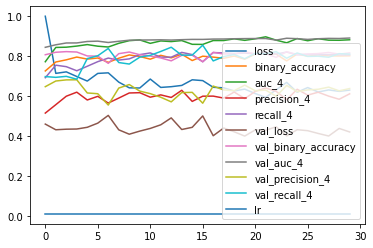

In [ ]:
result_resnet152.plot()

## Ensembling

For an ensemble model, it will be the the weighted average of previously trained model.

In [211]:
#save prediction from each model
proba_vgg = model_vgg16.predict(test_data_vgg)
proba_effnet = model_effnetb0.predict(test_data_eff)
proba_xception = model_xception.predict(test_data_xcep)
proba_densenet = model_densenet121_tuned.predict(test_data_dense)
proba_resnet = model_resnet152.predict(test_data_res)

In [227]:
models_predictions = [
    proba_vgg,
    proba_effnet,
    proba_xception,
    proba_densenet,
    proba_resnet
]

In [228]:
#assigning weights to respective model
weights = [
    0.1,     #weights for vgg16
    0.1,     #weights for efficientnet 
    0.1,     #weights for xception
    0.5,     #weigths for densenet
    0.2      #weights for resnet
]
for i in range(len(models_predictions)):
   models_predictions[i] = weights[i] * models_predictions[i]

#weighted average of ensembled model
ensemble_pred = np.sum(models_predictions,axis=0)

In [191]:
#since we are only going to extract the label information, the preprocessing in test_data does not matter
y = np.concatenate([label for image, label in test_data_xcep], axis=0)

In [229]:
acc = accuracy_score(y, np.round(ensemble_pred))
roc = roc_auc_score(y, (ensemble_pred))
prec = precision_score(y, np.round(ensemble_pred))
recal = recall_score(y, np.round(ensemble_pred))

print(f"accuracy: {acc}")
print(f"auc_roc: {roc}")
print(f"precision: {prec}")
print(f"recall: {recal}")

ensemble_eval = ["_", acc, roc, prec, recal]

accuracy: 0.8637059724349158
auc_roc: 0.9248503162741161
precision: 0.7444497493435187
recall: 0.7916481563749445


# Evaluation

Among all the pretrained models, an ensemble performed the best on the unseen test data.

In [230]:
pd.DataFrame(
    data= [
           vgg16_eval[1:],
           effnet_eval[1:],
           xception_eval[1:],
           densenet_eval[1:],
           tuned_densenet[1:],
           resnet_eval[1:],
           ensemble_eval[1:]
     ],
     columns=[
              'accuracy',
              'auc_roc',
              'precision',
              'recall'
    ],
    index=[
           'VGG16',
           'EfficientNetB0',
           'Xception',
           'DenseNet',
           'DenseNet(tuned)',
           'ResNet',
           "Ensemble(5 models)"
    ]
)

,accuracy,auc_roc,precision,recall
VGG16,0.845365,0.897877,0.732711,0.716761
EfficientNetB0,0.840771,0.893415,0.716584,0.726407
Xception,0.838681,0.896545,0.705417,0.741321
DenseNet,0.853202,0.908131,0.730898,0.764295
DenseNet(tuned),0.858733,0.922759,0.726171,0.806499
ResNet,0.819998,0.887550,0.652073,0.784540
Ensemble(5 models),0.863706,0.924850,0.744450,0.791648


## Confusion matrix & ROC AUC

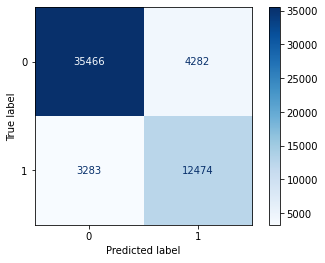

In [231]:
#print confusion matrix
cm = confusion_matrix(y, np.round(ensemble_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues");

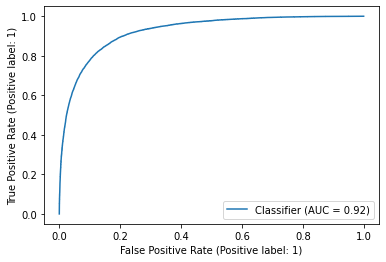

In [232]:
RocCurveDisplay.from_predictions(y, ensemble_pred);

# Conclusion

Transfer learning has proven capable of learninig to differentiate between cancerous tissues and non-cancerous. 

In the best performing ensemble model, it has
- 86% accuracy
- 0.92 roc auc
- 74% precision
- 79% recall